This notebook replicates the code for Lesson 8 of QF607

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Imported functions from Binomial](#p1)

# [2. Finite Difference Method](#p2)

# [3. Discretizing Time Dimension](#p3)

# [4. Test PDE](#p4)

In [1]:
import math
from enum import Enum
import numpy as np

import matplotlib.pyplot as plt

# <a id = "p1">1.</a>  <font color = "green"> Imported functions from Binomial </font>  [back to table of contents](#top)

In [2]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

In [3]:
# Black-Scholes analytic pricer
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

In [4]:
def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d1)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (1-cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)

In [5]:
class EuropeanOption():
  def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
  def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
  def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

In [6]:
def simpleCRR(r, vol, t):
    u = math.exp(vol * math.sqrt(t))
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1 / u, p)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

In [7]:
# Generical Binomial tree for various model defined in Calib 
def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

# <a id = "p2">2.</a>  <font color = "green"> Finite Difference Method </font>  [back to table of contents](#top)

In [8]:
function = lambda x: math.exp(x)

def functionderiv(x):
    return math.exp(x) 

In [9]:
function2 = lambda x: x* math.exp(x)

def function2deriv(x):
    return x* math.exp(x) +  math.exp(x)

In [10]:
def oneSide(func, x, h):
    return (func(x+h) - func(x))/ h

In [11]:
def centralDiff(func, x, h):
    return (func(x+h) - func(x-h))/(2*h)

In [12]:
def richardsonOneSide(func, x, h):
    return (4*oneSide(func,x,h/2) - oneSide(func,x,h))/3.0

def richardsonCentral(func, x, h):
    return (4*centralDiff(func,x,h/2) - centralDiff(func,x,h))/3.0

In [13]:
def testfinDiff(func):
    x0 = 1.0 #1
    deriv = functionderiv(x0)
    h = 0.2 #1
    n = 60
    hs = [h] * n
    errOneSide = [0] * n
    errCentralDiff = [0] * n
    errRichardsonOneSide = [0] * n
    errRichardsonCentralDiff = [0] * n
    for i in range(0, n):
        finDiffOneSide = oneSide(func, x0, h) 
        finDiffCentral = centralDiff(func, x0, h) 
        finDiffRichardsonOneSide = richardsonOneSide(func, x0, h) 
        finDiffRichardsonCentralDiff = richardsonCentral(func, x0, h) 
        hs[i] = h
        h = h/2
        errOneSide[i] = abs(finDiffOneSide - deriv)
        errCentralDiff[i] = abs(finDiffCentral - deriv)
        errRichardsonOneSide[i] = abs(finDiffRichardsonOneSide - deriv)
        errRichardsonCentralDiff[i] = abs(finDiffRichardsonCentralDiff - deriv)
        
    plt.plot(hs, errOneSide, label="finDiff error One Side")
    plt.plot(hs, errCentralDiff, label="finDiff error Central")
    plt.plot(hs, errRichardsonOneSide, label="Richardson error One Side")
    plt.plot(hs, errRichardsonCentralDiff, label="Richardson error Central Diff")
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

# <a id = "p3">3.</a>  <font color = "green"> Discretizing Time Dimension </font>  [back to table of contents](#top)

In [14]:
class BoundaryType(Enum):
    Dirichlet = 0
    Neumann = 1
    Linear = 2

In [15]:
def pdeExplicitPricer(S0, r, q, vol, NS, NT, bTy, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    srange = 5 * vol * math.sqrt(T)
    maxS = S0 * math.exp((mu - vol * vol * 0.5)*T + srange)
    minS = S0 * math.exp((mu - vol * vol * 0.5)*T - srange)
    dt = T / (NT-1)
    ds = (maxS - minS) / (NS-1)
    # set up spot grid
    sGrid = np.array([minS + i*ds for i in range(NS)])
    # initialize the payoff
    ps = np.array([trade.payoff(s) for s in sGrid])
    # set up the matrix, for BS the matrix does not change
    # for LV we need to update it for each iteration
    a, b = mu/2.0/ds, vol * vol / ds / ds
    M = np.zeros((NS, NS))
    D = np.zeros((NS, NS))
    for i in range (1, NS-1):
        M[i, i-1] = a*sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        M[i, i] = r + b * sGrid[i] * sGrid[i]
        M[i, i+1] = -a * sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        D[i,i] = 1.0
    # the first row and last row depends on the boundary condition
    if bTy == BoundaryType.Dirichlet:
        M[0,0], M[NS-1, NS-1] = 1.0, 1.0
    elif bTy == BoundaryType.Neumann:
        M[0,0], M[0,1] = -1.0, 1.0
        M[NS-1, NS-2], M[NS-1, NS-1] = 1.0
    elif bTy == BoundaryType.Linear:
        M[0,0], M[0,1], M[0,2] = 1, -2, 1
        M[NS-1, NS-3], M[NS-1, NS-2], M[NS-1, NS-1] = 1, -2, 1
    else:
        raise Exception("boundary condition not supported: ", bTy)

    M = D - dt * M
    # backward induction
    for j in range(1, NT):
        ps = M.dot(ps)  # Euler explicit
        if bTy == BoundaryType.Dirichlet:
            ps[0] = math.exp(-r*j*dt) * trade.payoff(sGrid[0]) # discounted payoff
            ps[NS-1] = math.exp(-r*j*dt) * trade.payoff(sGrid[NS-1])
        else:
            raise Exception("boundary type not implemented: ", bTy)
    # linear interpolate the price at S0
    return np.interp(S0, sGrid, ps)

In [16]:
def pdeImplicitPricer(S0, r, q, vol, NS, NT, bTy, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    srange = 5 * vol * math.sqrt(T)
    maxS = S0 * math.exp((mu - vol * vol * 0.5)*T + srange)
    minS = S0 * math.exp((mu - vol * vol * 0.5)*T - srange)
    dt = T / (NT-1)
    ds = (maxS - minS) / (NS-1)
    # set up spot grid
    sGrid = np.array([minS + i*ds for i in range(NS)])
    # initialize the payoff
    ps = np.array([trade.payoff(s) for s in sGrid])
    # set up the matrix, for BS the matrix does not change
    # for LV we need to update it for each iteration
    a, b = mu/2.0/ds, vol * vol / ds / ds
    M = np.zeros((NS, NS))
    D = np.zeros((NS, NS))
    for i in range (1, NS-1):
        M[i, i-1] = a*sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        M[i, i] = r + b * sGrid[i] * sGrid[i]
        M[i, i+1] = -a * sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        D[i,i] = 1.0
    # the first row and last row depends on the boundary condition
    if bTy == BoundaryType.Dirichlet:
        M[0,0], M[NS-1, NS-1] = 1.0, 1.0
    elif bTy == BoundaryType.Neumann:
        M[0,0], M[0,1] = -1.0, 1.0
        M[NS-1, NS-2], M[NS-1, NS-1] = 1.0
    elif bTy == BoundaryType.Linear:
        M[0,0], M[0,1], M[0,2] = 1, -2, 1
        M[NS-1, NS-3], M[NS-1, NS-2], M[NS-1, NS-1] = 1, -2, 1
    else:
        raise Exception("boundary condition not supported: ", bTy)

    M = D + dt * M
    M = np.linalg.inv(M)
    # backward induction
    for j in range(1, NT):
        if bTy == BoundaryType.Dirichlet:
            ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(sGrid[0]) # discounted payoff
            ps[NS-1] = dt*math.exp(-r*j*dt) * trade.payoff(sGrid[NS-1])
        else:
            raise Exception("boundary type not implemented: ", bTy)
        ps = M.dot(ps)  # Euler implicit
    # linear interpolate the price at S0
    return np.interp(S0, sGrid, ps)

In [17]:
def pdeDouglasPricer(S0, r, q, vol, NS, NT, w, bTy, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    srange = 5 * vol * math.sqrt(T)
    maxS = S0 * math.exp((mu - vol * vol * 0.5)*T + srange)
    minS = S0 * math.exp((mu - vol * vol * 0.5)*T - srange)
    dt = T / (NT-1)
    ds = (maxS - minS) / (NS-1)
    # set up spot grid
    sGrid = np.array([minS + i*ds for i in range(NS)])
    # initialize the payoff
    ps = np.array([trade.payoff(s) for s in sGrid])
    # set up the matrix, for BS the matrix does not change
    # for LV we need to update it for each iteration
    a, b = mu/2.0/ds, vol * vol / ds / ds
    M = np.zeros((NS, NS))
    D = np.zeros((NS, NS))
    for i in range (1, NS-1):
        M[i, i-1] = a*sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        M[i, i] = r + b * sGrid[i] * sGrid[i]
        M[i, i+1] = -a * sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        D[i,i] = 1.0
    # the first row and last row depends on the boundary condition
    if bTy == BoundaryType.Dirichlet:
        M[0,0], M[NS-1, NS-1] = 1.0, 1.0
    elif bTy == BoundaryType.Neumann:
        M[0,0], M[0,1] = -1.0, 1.0
        M[NS-1, NS-2], M[NS-1, NS-1] = 1.0
    elif bTy == BoundaryType.Linear:
        M[0,0], M[0,1], M[0,2] = 1, -2, 1
        M[NS-1, NS-3], M[NS-1, NS-2], M[NS-1, NS-1] = 1, -2, 1
    else:
        raise Exception("boundary condition not supported: ", bTy)

    rhsM = (D - dt * M) * w + (1-w) * np.identity(NS)
    lhsM = w * np.identity(NS) + (D + dt * M) * (1-w)
    inv = np.linalg.inv(lhsM)
    # backward induction
    for j in range(1, NT):
        ps = rhsM.dot(ps)
        if bTy == BoundaryType.Dirichlet:
            ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(sGrid[0]) # discounted payoff
            ps[NS-1] = dt*math.exp(-r*j*dt) * trade.payoff(sGrid[NS-1])
        else:
            raise Exception("boundary type not implemented: ", bTy)
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(S0, sGrid, ps)

In [18]:
def pdePricer(S0, r, q, vol, NX, NT, w, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    srange = 5 * vol * math.sqrt(T)
    maxX = X0 + (mu - vol * vol * 0.5)*T + srange
    minX = X0 - (mu - vol * vol * 0.5)*T - srange
    dt = T / (NT-1)
    dx = (maxX - minX) / (NX-1)
    # set up spot grid
    xGrid = np.array([minX + i*dx for i in range(NX)])
    # initialize the payoff
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    # set up the matrix, for BS the matrix does not change
    # for LV we need to update it for each iteration
    a = (mu - vol*vol/2.0)/2.0/dx - vol*vol/2/dx/dx
    b = r + vol * vol / dx / dx
    c = -(mu - vol*vol/2.0)/2.0/dx - vol*vol/2/dx/dx
    M = np.zeros((NX, NX))
    D = np.zeros((NX, NX))
    for i in range (1, NX-1):
        M[i,i-1] = a
        M[i, i] = b
        M[i, i+1] = c
        D[i,i] = 1.0
    # the first row and last row depends on the boundary condition
    M[0,0], M[NX-1, NX-1] = 1.0, 1.0
    rhsM = (D - dt * M) * w + (1-w) * np.identity(NX)
    lhsM = w * np.identity(NX) + (D + dt * M) * (1-w)
    inv = np.linalg.inv(lhsM)
    # backward induction
    for j in range(1, NT):
        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[0])) # discounted payoff
        ps[NX-1] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[NX-1]))
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(X0, xGrid, ps)

# <a id = "p4">4.</a>  <font color = "green"> Test PDE </font>  [back to table of contents](#top)

In [19]:
def testPDE():
    opt = EuropeanOption(1, 101, PayoffType.Call)
    S, r, vol = 100, 0.01, 0.2

    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)
    n = 400

    pdeErrsE = [(abs(pdeExplicitPricer(S, r, 0.0, vol, int(math.sqrt(i/vol)), i, BoundaryType.Dirichlet, opt) - bsprc)) for i in range(10, n, 2)]
    pdeErrsI = [(abs(pdeImplicitPricer(S, r, 0.0, vol, i, i, BoundaryType.Dirichlet, opt) - bsprc)) for i in range(10, n, 2)]
    pdeCN = [(abs(pdeDouglasPricer(S, r, 0.0, vol, i, i, 0.5, BoundaryType.Dirichlet, opt) - bsprc)) for i in range(10, n, 2)]
    pdeDG = [(abs(pdeDouglasPricer(S, r, 0.0, vol, i, i, 0.5 - 1/12/i, BoundaryType.Dirichlet, opt) - bsprc)) for i in
             range(10, n, 2)]
    pdeLogSCN = [(abs(pdePricer(S, r, 0.0, vol, i, i, 0.5, opt) - bsprc)) for i in range(10, n, 2)]
    crrErrs = [(abs(binomialPricer(S, r, vol, opt, i, crrCalib) - bsprc)) for i in range(10, n, 2)]
    # jrrnErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jrrnCalib) - bsprc)) for i in range(1, n)]
    # jreqErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jreqCalib) - bsprc)) for i in range(1, n)]
    # tianErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, tianCalib) - bsprc)) for i in range(1, n)]

    plt.plot(range(10, n, 2), crrErrs, label="crr binomial")
    plt.plot(range(10, n, 2), pdeErrsE, label="pde explicit")
    plt.plot(range(10, n, 2), pdeErrsI, label="pde implicit")
    plt.plot(range(10, n, 2), pdeCN, label="pde crank-nicholson")
    plt.plot(range(10, n, 2), pdeLogSCN, label="pde logS")
    plt.plot(range(10, n, 2), pdeDG, label="pde douglas 1/2 - 1/12/i")
    # plt.plot(range(1, n), jrrnErrs, label="jrrn")
    # plt.plot(range(1, n), jreqErrs, label="jreq")
    # plt.plot(range(1, n), tianErrs, label="tian")
    plt.yscale('log')
    plt.xlabel('NT'), plt.ylabel('Error')
    plt.legend()
    #plt.savefig('../figs/pdeCKError.eps', format='eps')
    plt.show()

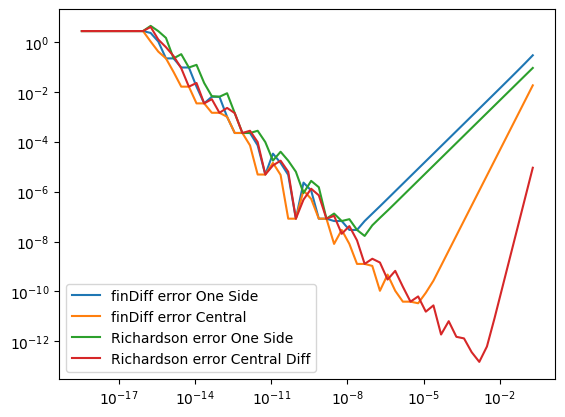

In [20]:
testfinDiff(function)

bsPrice = 	  7.967853279332552


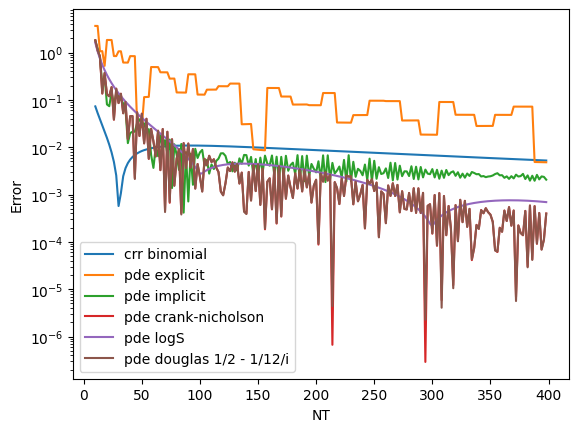

In [21]:
testPDE()